<a href="https://colab.research.google.com/github/eadelgadillom/Astronomia_fundamental/blob/main/Borrador_w_rotaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numpy as np
from scipy.optimize import root_scalar
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt

In [ ]:
# Efemerides Tierra
a_tierra = (1.495582533630905E+8*u.km).to('au')
ecc_tierra = 1.694863932474438E-02
omega_tierra = 1.498625963929686E+02*u.deg
w_tierra = 3.146587763491455E+02*u.deg
i_tierra = 4.164075603038432E-03*u.deg
n_tierra = 1.141204629731537E-05*u.deg/u.s
l0_tierra = 1.817846947871890E+02*u.deg

#Transformacion de unidades grado-radián
omega_tierra = omega_tierra.to('rad')
w_tierra = w_tierra.to('rad')
i_tierra = i_tierra.to('rad')
n_tierra = n_tierra.to('rad/s')
l0_tierra = l0_tierra.to('rad')

In [ ]:
GM_sol = 132712440041.93938*u.km**3/u.s**2
GM_sol = GM_sol.to("au**3/day**2")

In [ ]:
## Funciones de la Tierra
def Kepler_ellpitic(E, l, ecc):
    f = E - ecc*np.sin(E) - l
    fprime = 1 - ecc*np.cos(E)
    return f, fprime

def find_iota(t, l0, n, t0,):
    return (l0 + n*(t-t0))

def find_f_elliptic(e, E):
    root_term = np.sqrt( (1+e)/(1-e) )
    right_side = root_term*np.tan(E/2)
    f = 2*np.arctan(right_side)
    return f

def find_r_elliptic(a, ecc, E):
    return a*(1 - ecc*np.cos(E))

def find_xyz (r, Om, phi, i):
    x = r*(np.cos(Om)*np.cos(phi) - np.cos(i)*np.sin(Om)*np.sin(phi))
    y = r*(np.sin(Om)*np.cos(phi) + np.cos(i)*np.cos(Om)*np.sin(phi))
    z = r*(np.sin(i)*np.sin(phi))
    return (x, y, z)

def find_norm(vector):
    num = np.sqrt(vector[0].value**2 + vector[1].value**2 + vector[2].value**2)
    return num

In [ ]:
##___________________________________________________________________________________________________________________________________________________________##
def Kepler_hyperbolic(E, l, ecc):
    f = ecc*np.sinh(E) - E - l
    fprime = ecc*np.cosh(E) - 1
    return f, fprime

In [ ]:
## Funciones del cometa
def find_phi_cometa(xyz_vector, r_vector, inclinacion_vector):
    phi_vector = []
    for ii in range (len(xyz_vector)):
        inclinacion = inclinacion_vector
        #z = (xyz_vector[ii][2]*u.au).to('km')
        z = xyz_vector[ii][2]
        #inside = z.value / (r_vector[ii]*np.sin(inclinacion))
        inside = z / (r_vector[ii]*np.sin(inclinacion))
        if inside > 1:
            inside = 1*u.km/u.km
        phi = np.arcsin(inside)
        phi_vector.append(phi)
    return phi_vector

def find_velocidad():
    # Se usa el método del punto medio
    h = tiempos_cometa_inicial[1].utc- tiempos_cometa_inicial[0]
    velocidades_cometa_inicial = [0,0,0]

    for ii in range (3):
        velocidades_cometa_inicial[ii] = (coor_cometa_inicial[2][ii]*u.au - coor_cometa_inicial[0][ii]*u.au) / (2*h)
    return velocidades_cometa_inicial

def find_inclination(xyz_vector, r_vector):
    inclinacion_vector = []
    for ii in range (len(xyz_vector)):
        xy0_vector = [xyz_vector[ii][0], xyz_vector[ii][1], 0]
        dot_product = np.dot(xyz_vector[ii], xy0_vector)
        magnitud_r = r_vector[ii]
        magnitud_rz = np.linalg.norm(xy0_vector)
        inclinacion = np.arccos(dot_product/(magnitud_r*magnitud_rz))
        inclinacion_vector.append(inclinacion)
    return (inclinacion_vector)*u.rad

def find_f_hyperbolic(e, E):
    root_term = np.sqrt( (e+1)/(e-1) )
    right_side = root_term*np.tanh(E/2)
    f = 2*np.arctan(right_side)
    return f

def find_r_hyperbolic(a, ecc, E):
    return a*(1 - ecc*np.cosh(E))

def find_iota_hyperbolic(t, l0, n, t0,):
    return (n*(t-t0))

In [ ]:
## Parámetros temporales de la tierra
N_tiempos = (1*365)
t0 = Time('2023-07-09T00:00:00', scale='tdb', format = 'isot').utc
tf = Time('2024-07-09T00:00:00', scale='tdb', format = 'isot').utc
tiempos_evolucion = np.linspace(t0, tf, N_tiempos)

## Calculo orbita Tierra
plot_tierra_data = np.zeros((3, N_tiempos))
plot_cometa_data = np.zeros((3, N_tiempos))

for ii, t in enumerate(tiempos_evolucion):
    ## 1. Hallar iota
    iota_tierra = find_iota(t, l0_tierra, n_tierra, t0)


    ## 2. Solucionar la Ec. de Kepler
    # E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), bracket=[0, iota_tierra.value], method="brentq")
    E_raiz_tierra = root_scalar(Kepler_ellpitic, args=(iota_tierra.value, ecc_tierra), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_tierra = find_f_elliptic(ecc_tierra, E_raiz_tierra)
    #print(f_tierra)


    ## 4. Hallar phi
    phi_tierra = f_tierra + w_tierra


    ## 5. Hallar r
    r_tierra = find_r_elliptic(a_tierra, ecc_tierra, E_raiz_tierra)


    ## 6. Hallar x, y, z
    coor_tierra = find_xyz (r_tierra, omega_tierra, phi_tierra, i_tierra)
    for jj in range (3):
        plot_tierra_data[jj, ii] = coor_tierra[jj].value

In [ ]:
#PARÁMETROS DEL COMETA

## Parámetros temporales del cometa
tiempos_cometa_inicial = [
    Time('2023-07-09T10:00:00', scale='utc', format = 'isot'), Time('2023-07-09T12:00:00', scale='utc', format = 'isot'),
    Time('2023-07-09T14:00:00', scale='utc', format = 'isot'), Time('2023-08-03T11:00:00', scale='utc', format = 'isot'),
    Time('2023-08-15T08:00:00', scale='utc', format = 'isot'), Time('2023-08-21T09:00:00', scale='utc', format = 'isot')]

## Parámetros espaciales
coor_cometa_inicial = [
    [-136.5637561083746,  -58.86174117642695,  0.006477038631585696],
    [-136.52944516728272, -58.8582744676107,   0.006476657161271048],
    [-136.49508281581126, -58.85478559561711,  0.006476273252160792],
    [-123.8254221225029,  -56.75184521313076,  0.006244869528365741],
    [-115.92607005859432, -54.90754850330492,  0.0060419264825281455],
    [-111.38702385389293, -53.724113572894545, 0.0059117034614445335]]

In [ ]:
## CÁLCULOS COMETA

## Hallamos vector r del cometa
r_cometa_inicial = [np.linalg.norm(coor_cometa_inicial[ii]) for ii in range (6)]

## Hallamos Velocidad v del cometa
velocidades_cometa_inicial = find_velocidad()
velocidades_cometa_inicial_valor = []

for ii in range (3):
    velocidades_cometa_inicial_valor.append(velocidades_cometa_inicial[ii].value)

## Hallamos momento angular L
L_cometa =  np.cross(coor_cometa_inicial[1], velocidades_cometa_inicial_valor) #au**2/day

## Hallamos la excentricidad e
ecc_cometa_vector = np.cross(velocidades_cometa_inicial_valor, L_cometa) / GM_sol.value - coor_cometa_inicial[1]/r_cometa_inicial[1]
ecc_cometa = np.linalg.norm(ecc_cometa_vector)

## Hallamos el semilactus rectum P
P_cometa = ((np.linalg.norm(L_cometa)*u.au**2/u.day)**2) / GM_sol

## Hallamos Perihelio
perihelio_cometa = P_cometa / (1 + ecc_cometa)

## Hallamos el semieje mayor
aux_top = GM_sol*r_cometa_inicial[1]*u.au
aux_bot = 2*GM_sol - r_cometa_inicial[1]*u.au*np.linalg.norm(velocidades_cometa_inicial_valor)**2*(u.au/u.day)**2
a_cometa = aux_top / aux_bot ## Expresión de https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Celestial_Mechanics_(Tatum)/10%3A_Computation_of_an_Ephemeris/10.06%3A_Elements_of_a_Hyperbolic_Orbit


## Hallamos la energia especifica del sistema
energia_e_cometa = -GM_sol  / (2*a_cometa) ##energia > 0 orbita hiperbolica
energia_e_tierra = -GM_sol / (2*a_tierra) ## energia < 0 orbita eliptica

## hallamos el angulo de inclinacion de la orbita del cometa
i_cometa = np.arccos(L_cometa[2]/np.linalg.norm(L_cometa))*u.rad

## Hallamos la longitud del nodo ascendente omega
n = np.cross([0, 0, 1], L_cometa)
omega_cometa = np.arccos(n[0] / np.linalg.norm(n))*u.rad

## Hallamos el argumento del pericentro
w_cometa = np.arccos(np.dot(n , ecc_cometa_vector) / (np.linalg.norm(n) * ecc_cometa))*u.rad

In [ ]:
(np.pi - w_cometa.value)*u.radian
w_cometa

<Quantity 1.67177391 rad>

In [ ]:
# Comparacion efemerides  cometa vs tierra
print('Comparacion efemerides cometa vs tierra')
print('Energias =', energia_e_cometa, energia_e_tierra)
print('semieje mayor  a =', a_cometa, a_tierra)
print('excentricidad e = ', ecc_cometa, ecc_tierra)
print('inclinacion i =', i_cometa, i_tierra)
print('nodo ascentente \u03A9 = ', omega_cometa, omega_tierra)
print('argumento del pericentro w =', w_cometa, w_tierra)

Comparacion efemerides cometa vs tierra
Energias = 0.08575723158219534 AU2 / d2 -0.0001479952970772798 AU2 / d2
semieje mayor  a = -0.0017252901173819345 AU 0.9997351744598761 AU
excentricidad e =  25967.33465426792 0.01694863932474438
inclinacion i = 0.00011003817552377976 rad 7.267682957498903e-05 rad
nodo ascentente Ω =  3.141592653589793 rad 2.6155957326446804 rad
argumento del pericentro w = 1.671773906408136 rad 5.491831667589052 rad


In [ ]:
def find_r_hyperbolic(a, ecc, f):
    top = a*(1-ecc*2)
    bot = 1 + np.cos(f)
    return top/bot


## Hallamos parámetros inicializadores
E_0_cometa = np.arccosh((1 - r_cometa_inicial[1]/a_cometa.value)/np.linalg.norm(ecc_cometa))
l0_cometa = ecc_cometa*np.sinh(E_0_cometa) - E_0_cometa
n_cometa = np.sqrt(GM_sol/-a_cometa**3)
t0_cometa = tiempos_cometa_inicial[1]


for ii, t in enumerate(tiempos_evolucion):
    ## 1. Hallar iota
    iota_cometa = find_iota_hyperbolic(t, l0_cometa, n_cometa, t0_cometa)

    ## 2. Solucionar la Ec. de Kepler
    # E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), bracket=[0, iota_tierra.value], method="brentq")
    E_raiz_cometa = root_scalar(Kepler_hyperbolic, args=(iota_cometa.value, ecc_cometa), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_cometa = find_f_hyperbolic(ecc_cometa, E_raiz_cometa)


    ## 4. Hallar phi
    phi_cometa = f_cometa + w_cometa


    ## 5. Hallar r
    #r_cometa = find_r_hyperbolic(a_cometa, ecc_cometa, E_raiz_cometa)
    r_cometa = find_r_hyperbolic(a_cometa, ecc_cometa, f_cometa)
    print(r_cometa)

    ## 6. Hallar x, y, z
    coor_cometa = find_xyz (r_cometa, omega_cometa, phi_cometa, i_cometa)
    for jj in range (3):
        plot_cometa_data[jj, ii] = coor_cometa[jj].value


44.800563277129996 AU
44.80056702398915 AU
44.802506087632956 AU
44.80637946319005 AU
44.812185144486456 AU
44.81992012729023 AU
44.82958041416313 AU
44.84116102090305 AU
44.854655984555386 AU
44.8700583729667 AU
44.88736029584863 AU
44.90655291731552 AU
44.92762646985437 AU
44.95057026968132 AU
44.975372733434995 AU
45.00202139615272 AU
45.03050293047252 AU
45.06080316700021 AU
45.09290711577801 AU
45.126798988788806 AU
45.162462223427205 AU
45.199879506867575 AU
45.239032801256705 AU
45.279903369658264 AU
45.32247180267479 AU
45.366718045672904 AU
45.41262142653668 AU
45.46016068387472 AU
45.50931399560665 AU
45.56005900785554 AU
45.612372864073706 AU
45.666232234330856 AU
45.72161334469485 AU
45.778492006637265 AU
45.83684364639793 AU
45.89664333424483 AU
45.95786581356809 AU
46.02048552974943 AU
46.08447665875097 AU
46.14981313537029 AU
46.21646868111133 AU
46.28441683162403 AU
46.35363096366813 AU
46.42408432156023 AU
46.49575004306589 AU
46.56860118470188 AU
46.642610746416736 AU

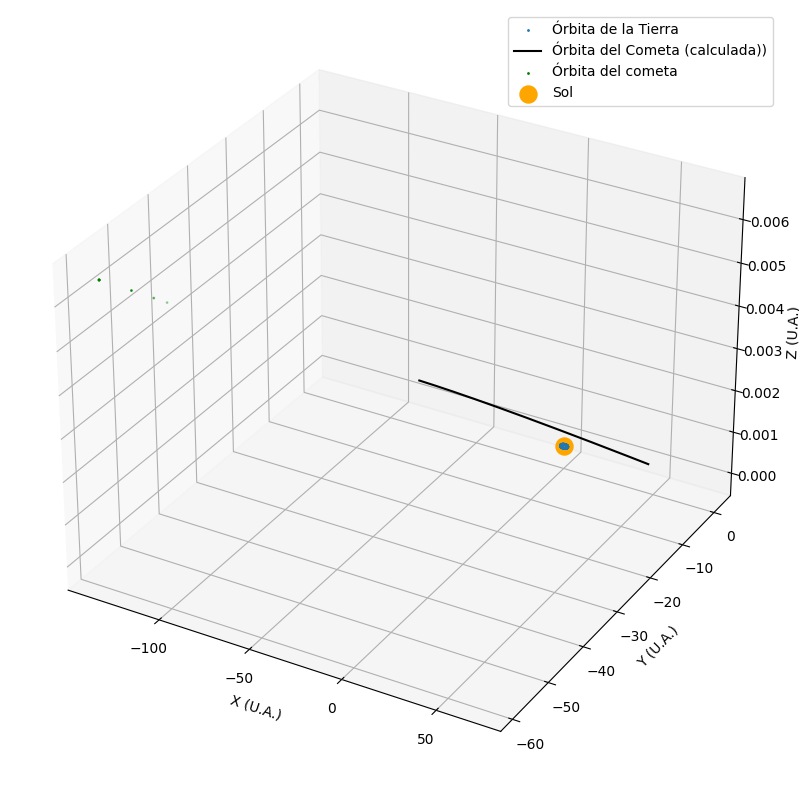

In [ ]:
coor_cometa_inicial = np.transpose(coor_cometa_inicial)
## Plot de las ótbita
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(plot_tierra_data[0], plot_tierra_data[1], plot_tierra_data[2], label='Órbita de la Tierra', s=1)
ax.plot(plot_cometa_data[0], plot_cometa_data[1], plot_cometa_data[2], label='Órbita del Cometa (calculada))' , color="black")

ax.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], coor_cometa_inicial[2], label='Órbita del cometa', s=1, color="green")
ax.scatter(0, 0, 0, s=150, label='Sol', color="orange")

ax.legend()
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
#ax.set_zlim(-1, 1)
ax.set_xlabel('X (U.A.)')
ax.set_ylabel('Y (U.A.)')
ax.set_zlabel('Z (U.A.)')


plt.show()

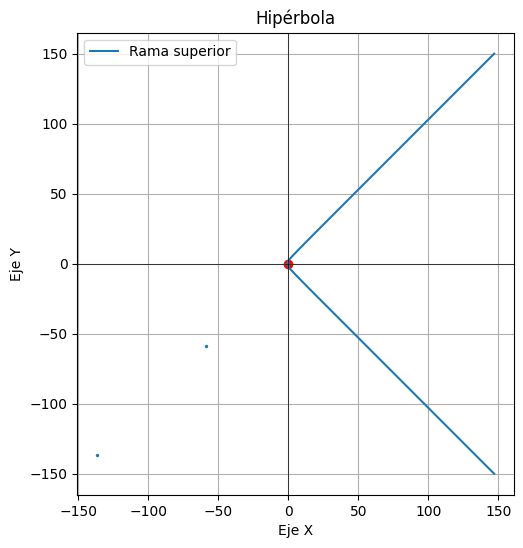

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la hipérbola
excentricidad = 1.5  # Reemplaza esto con tu excentricidad
semieje_mayor = 2.0  # Reemplaza esto con tu distancia del semieje mayor

# Distancia focal
distancia_focal = semieje_mayor * excentricidad

# Crear puntos en el eje x
y = np.linspace(-150, 150, 400)

# Calcular los valores correspondientes en el eje y
x = np.sqrt(semieje_mayor**2 * (excentricidad**2 - 1) + (y)**2) - distancia_focal

# Coordenadas del foco
foco_x = 0
foco_y = 0

# Graficar la hipérbola
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Rama superior')
#plt.plot(x, y2, label='Rama inferior')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Hipérbola')
plt.legend()
plt.grid(True)
plt.scatter([foco_x], [foco_y], color='red', label='Foco')
plt.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], label='Órbita del cometa', s=2)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

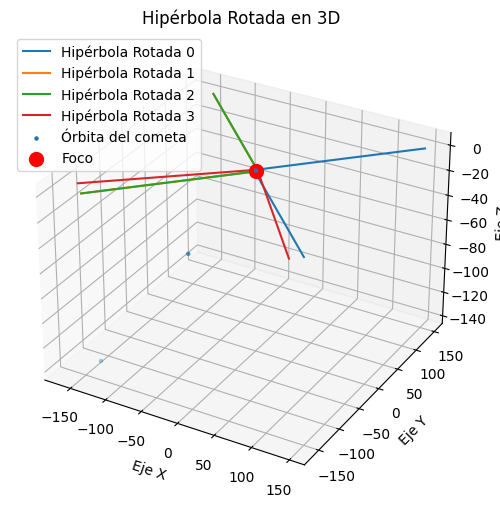

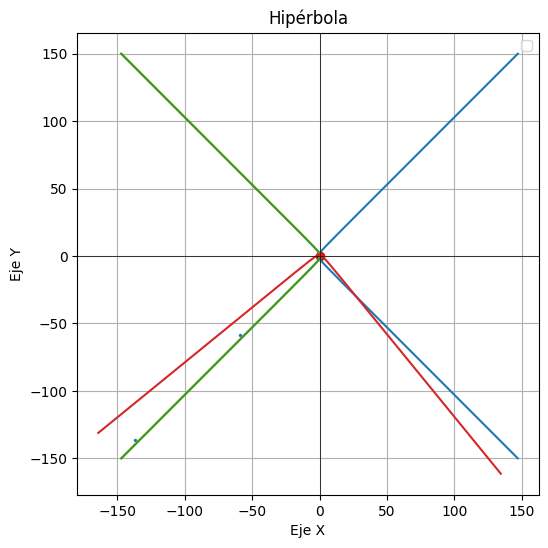

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros de la hipérbola
excentricidad = 1.5  # Reemplaza esto con tu excentricidad
semieje_mayor = 2.0  # Reemplaza esto con tu distancia del semieje mayor

# Distancia focal
distancia_focal = semieje_mayor * excentricidad

# Crear puntos en el eje x
y = np.linspace(-150, 150, 600)
z = np.zeros(600)

# Calcular los valores correspondientes en el eje y
x = np.sqrt(semieje_mayor**2 * (excentricidad**2 - 1) + (y)**2) - distancia_focal

# Coordenadas del foco
foco_y = 0
foco_x = 0

# Ángulo de rotación en grados alrededor del eje z
angulo_rotacion = 0  # Cambia el ángulo de rotación según tus necesidades

# Convertir el ángulo de rotación a radianes
angulo_rad = np.radians(angulo_rotacion)


Omega = -3.14159
iota = -0.00011
omega = -(1.67177 + np.pi)
# Matriz de rotación 3D alrededor del eje z
R_Omega = np.array([[np.cos(Omega), -np.sin(Omega), 0],
              [np.sin(Omega), np.cos(Omega), 0],
              [0, 0, 1]])

R_iota = np.array([[1,0,0],[0, np.cos(iota), -np.sin(iota)],
              [0, np.sin(iota), np.cos(iota)]])

R_omega = np.array([[np.cos(omega), -np.sin(omega), 0],
              [np.sin(omega), np.cos(omega), 0],
              [0, 0, 1]])

# Aplicar la rotación a las coordenadas (x, y)
coordenadas_rotadas_0 = np.vstack((x,y,z))
coordenadas_rotadas_1 = np.dot(R_Omega, coordenadas_rotadas_0)
coordenadas_rotadas_2 = np.dot(R_iota,  coordenadas_rotadas_1)
coordenadas_rotadas_3 = np.dot(R_omega, coordenadas_rotadas_2)

# Graficar la hipérbola rotada en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(coordenadas_rotadas_0[0], coordenadas_rotadas_0[1], coordenadas_rotadas_0[2], label='Hipérbola Rotada 0')
ax.plot(coordenadas_rotadas_1[0], coordenadas_rotadas_1[1], coordenadas_rotadas_1[2], label='Hipérbola Rotada 1')
ax.plot(coordenadas_rotadas_2[0], coordenadas_rotadas_2[1], coordenadas_rotadas_2[2], label='Hipérbola Rotada 2')
ax.plot(coordenadas_rotadas_3[0], coordenadas_rotadas_3[1], coordenadas_rotadas_3[2], label='Hipérbola Rotada 3')
ax.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], coor_cometa_inicial[2], label='Órbita del cometa', s=5)
ax.line
ax.scatter([foco_x], [foco_y], [0], color='red', s=100, label='Foco')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
ax.set_title('Hipérbola Rotada en 3D')
ax.legend()
plt.show()

plt.figure(figsize=(8, 6))
#plt.plot(x, y, label='Rama superior')
#plt.plot(x, y2, label='Rama inferior')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Hipérbola')
plt.legend()
plt.grid(True)
plt.scatter([foco_x], [foco_y], color='red', label='Foco')
plt.plot(coordenadas_rotadas_0[0], coordenadas_rotadas_0[1], label='Hipérbola Rotada 0')
plt.plot(coordenadas_rotadas_1[0], coordenadas_rotadas_1[1], label='Hipérbola Rotada 1')
plt.plot(coordenadas_rotadas_2[0], coordenadas_rotadas_2[1], label='Hipérbola Rotada 2')
plt.plot(coordenadas_rotadas_3[0], coordenadas_rotadas_3[1], label='Hipérbola Rotada 3')
plt.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], label='Órbita del cometa', s=2)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()